In [2]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_ibm_provider import IBMProvider
from qiskit.quantum_info import Operator

C:\Users\azadp\AppData\Local\Temp\ipykernel_73312\3510736368.py:7: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [3]:
api_token='IBM TOKEN'

IBMProvider.save_account(api_token, overwrite=True)
provider = IBMProvider()
print("Available backends:", provider.backends())

Available backends: [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_kyiv')>]


In [4]:
def oracle(n,indices_to_mark,name='Oracle'):
    qc = QuantumCircuit(n,name=name)
    oracle_matrix=np.identity(2**n)
    for indx in indices_to_mark:
        oracle_matrix[indx,indx]=-1
    qc.unitary(Operator(oracle_matrix),range(n))
    return qc
    

In [8]:
def diffuser(n):
    qc = QuantumCircuit(n, name='V')
    qc.h(range(n))
    qc.append(oracle(n,[0]),range(n))
    qc.h(range(n))
    return qc

In [9]:
def grover(n,marked):
    qc = QuantumCircuit(n,n)
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    qc.h(range(n))
    for _ in range(r):
        qc.append(oracle(n,marked),range(n))
        qc.append(diffuser(n),range(n))
    qc.measure(range(n),range(n))
    return qc    



5 qubits, basis state [14, 24] marked, 3 rounds


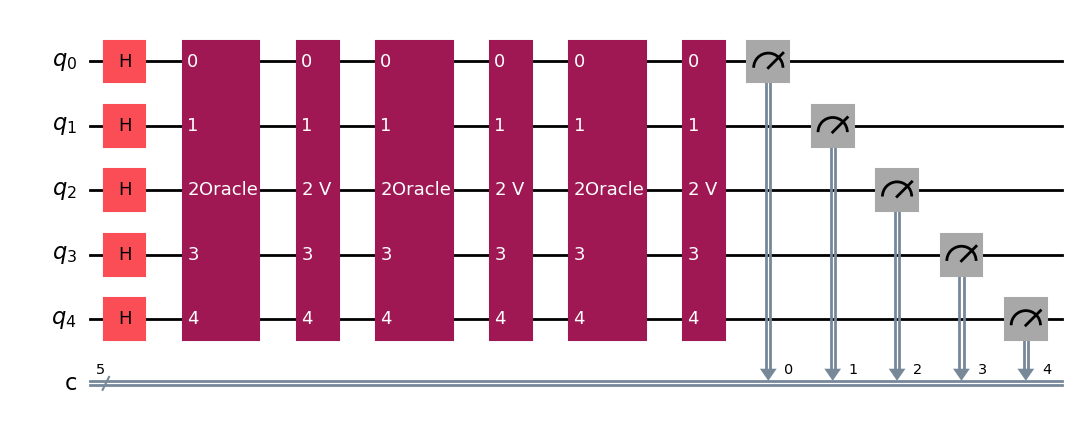

In [41]:
n = 5
x=np.random.randint(2**n)
y=np.random.randint(2**n)
qc = grover(n,[x,y])
qc.draw(output="mpl")

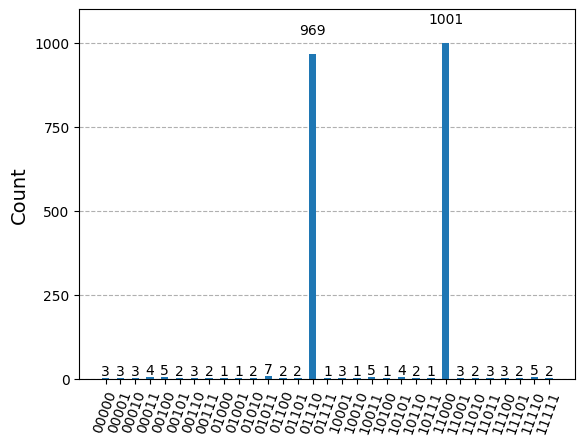

In [42]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qc, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

In [43]:
backends = provider.backends(filters=lambda b: b.status().operational and not b.configuration().simulator)
least_busy_backend = min(backends, key=lambda b: b.status().pending_jobs)


In [44]:
shots = 2048
transpiled_qc = transpile(qc, least_busy_backend, optimization_level=3)
job = least_busy_backend.run(transpiled_qc, shots=shots)

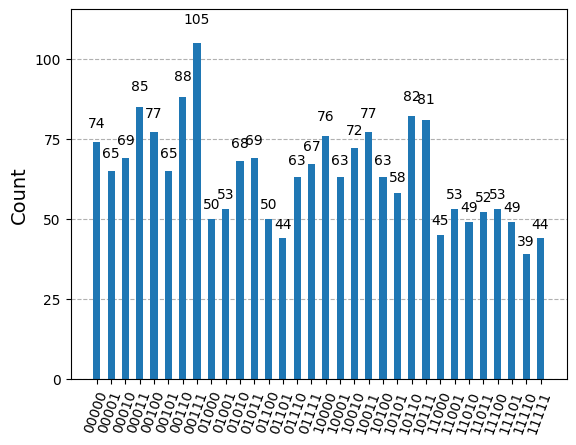

In [45]:
counts = job.result().get_counts()
plot_histogram(counts)